<a href="https://colab.research.google.com/github/SinghKavitha/YT-Video-Summarizer/blob/main/YT_video_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SUMMARISING ANY YOUTUBE VIDEO USING CHATGPT AND WHISPER:

HOW IT WORKS :-

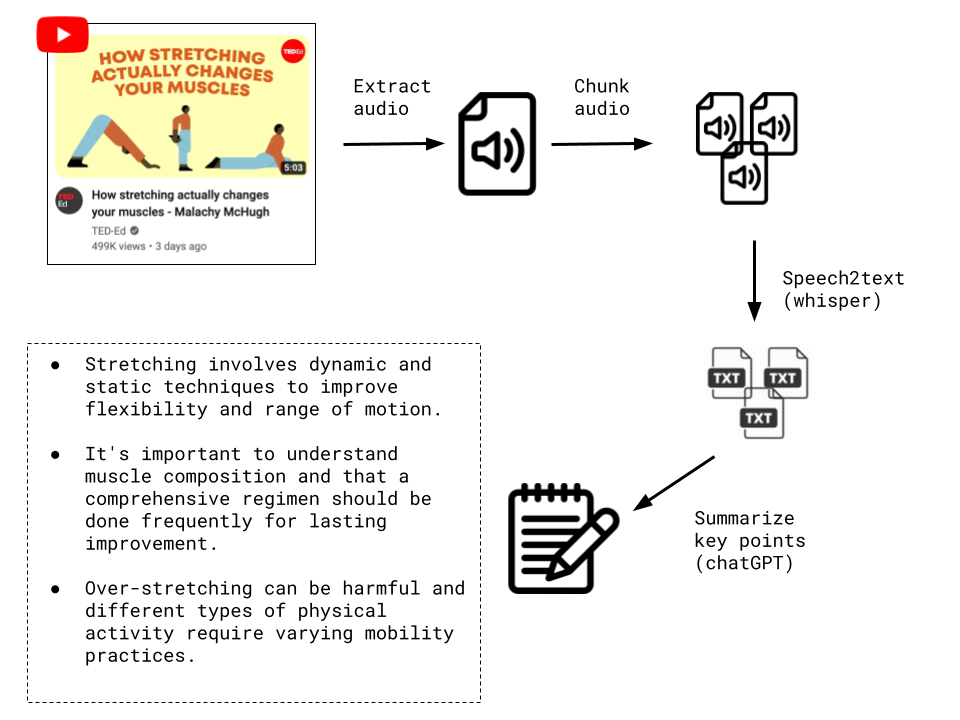

Imports and dependencies️

In [ ]:
import os
import shutil

import librosa
import openai
import soundfile as sf
import youtube_dl
from youtube_dl.utils import DownloadError

assert os.getenv("OPENAI_API_KEY") is not None, "Set your openAI API key"

Utility functions

In [ ]:
def find_audio_files(path, extension=".mp3"):
    """Recursively find all files with extension in path."""
    audio_files = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.endswith(extension):
                audio_files.append(os.path.join(root, f))

    return audio_files

In [ ]:
Download youtube audio

In [ ]:
def youtube_to_mp3(youtube_url: str, output_dir: str) -> str:
    """Download the audio from a youtube video, save it to output_dir as an .mp3 file.

    Returns the filename of the savied video.
    """

    # config
    ydl_config = {
        "format": "bestaudio/best",
        "postprocessors": [
            {
                "key": "FFmpegExtractAudio",
                "preferredcodec": "mp3",
                "preferredquality": "192",
            }
        ],
        "outtmpl": os.path.join(output_dir, "%(title)s.%(ext)s"),
        "verbose": True,
    }

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Downloading video from {youtube_url}")

    try:
        with youtube_dl.YoutubeDL(ydl_config) as ydl:
            ydl.download([youtube_url])
    except DownloadError:
        # weird bug where youtube-dl fails on the first download, but then works on second try... hacky ugly way around it.
        with youtube_dl.YoutubeDL(ydl_config) as ydl:
            ydl.download([youtube_url])

    audio_filename = find_audio_files(output_dir)[0]
    return audio_filename

Chunk the audio:-

Chunking is necessary in the case where we have very long audio files, since both whisper and ChatGPT have limits of how much audio/text you can process in one go. It is not necessary for shorter videos.

In [ ]:
def chunk_audio(filename, segment_length: int, output_dir):
    """segment lenght is in seconds"""

    print(f"Chunking audio to {segment_length} second segments...")

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    # load audio file
    audio, sr = librosa.load(filename, sr=44100)

    # calculate duration in seconds
    duration = librosa.get_duration(y=audio, sr=sr)

    # calculate number of segments
    num_segments = int(duration / segment_length) + 1

    print(f"Chunking {num_segments} chunks...")

    # iterate through segments and save them
    for i in range(num_segments):
        start = i * segment_length * sr
        end = (i + 1) * segment_length * sr
        segment = audio[start:end]
        sf.write(os.path.join(output_dir, f"segment_{i}.mp3"), segment, sr)

    chunked_audio_files = find_audio_files(output_dir)
    return sorted(chunked_audio_files)

Speech2text

In [ ]:
def transcribe_audio(audio_files: list, output_file=None, model="whisper-1") -> list:

    print("converting audio to text...")

    transcripts = []
    for audio_file in audio_files:
        audio = open(audio_file, "rb")
        response = openai.Audio.transcribe(model, audio)
        transcripts.append(response["text"])

    if output_file is not None:
        # save all transcripts to a .txt file
        with open(output_file, "w") as file:
            for transcript in transcripts:
                file.write(transcript + "\n")

    return transcripts

Finally Summarize

In [ ]:
def summarize(
    chunks: list[str], system_prompt: str, model="gpt-3.5-turbo", output_file=None
):

    print(f"Summarizing with {model=}")

    summaries = []
    for chunk in chunks:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": chunk},
            ],
        )
        summary = response["choices"][0]["message"]["content"]
        summaries.append(summary)

    if output_file is not None:
        # save all transcripts to a .txt file
        with open(output_file, "w") as file:
            for summary in summaries:
                file.write(summary + "\n")

    return summaries

Putting it all together

In [ ]:
def summarize_youtube_video(youtube_url, outputs_dir):
    raw_audio_dir = f"{outputs_dir}/raw_audio/"
    chunks_dir = f"{outputs_dir}/chunks"
    transcripts_file = f"{outputs_dir}/transcripts.txt"
    summary_file = f"{outputs_dir}/summary.txt"
    segment_length = 10 * 60  # chunk to 10 minute segments

    if os.path.exists(outputs_dir):
        # delete the outputs_dir folder and start from scratch
        shutil.rmtree(outputs_dir)
        os.mkdir(outputs_dir)

    # download the video using youtube-dl
    audio_filename = youtube_to_mp3(youtube_url, output_dir=raw_audio_dir)

    # chunk each audio file to shorter audio files (not necessary for shorter videos...)
    chunked_audio_files = chunk_audio(
        audio_filename, segment_length=segment_length, output_dir=chunks_dir
    )

    # transcribe each chunked audio file using whisper speech2text
    transcriptions = transcribe_audio(chunked_audio_files, transcripts_file)

    # summarize each transcription using chatGPT
    system_prompt = """
    You are a helpful assistant that summarizes youtube videos.
    You are provided chunks of raw audio that were transcribed from the video's audio.
    Summarize the current chunk to succint and clear bullet points of its contents.
    """
    summaries = summarize(
        transcriptions, system_prompt=system_prompt, output_file=summary_file
    )

    system_prompt_tldr = """
    You are a helpful assistant that summarizes youtube videos.
    Someone has already summarized the video to key points.
    Summarize the key points to one or two sentences that capture the essence of the video.
    """
    # put the entire summary to a single entry
    long_summary = "\n".join(summaries)
    short_summary = summarize(
        [long_summary], system_prompt=system_prompt_tldr, output_file=summary_file
    )[0]

    return long_summary, short_summary

In [ ]:
youtube_url = "https://www.youtube.com/watch?v=g1pb2aK2we4"
outputs_dir = "outputs/"

long_summary, short_summary = summarize_youtube_video(youtube_url, outputs_dir)

print("Summaries:")
print("=" * 80)
print("Long summary:")
print("=" * 80)
print(long_summary)
print()

print("=" * 80)
print("Video - TL;DR")
print("=" * 80)
print(short_summary)

[debug] Encodings: locale UTF-8, fs utf-8, out UTF-8, pref UTF-8
[debug] youtube-dl version 2021.12.17
[debug] Git HEAD: 6fece0a96
[debug] Python version 3.10.10 (CPython) - macOS-12.5.1-arm64-arm-64bit
[debug] exe versions: ffmpeg 5.1.2, ffprobe 5.1.2
[debug] Proxy map: {}


[youtube] g1pb2aK2we4: Downloading webpage
[debug] [youtube] Decrypted nsig W4nRgXSWiPJn52-Slf => OlowYsuH8lM-vw
[debug] [youtube] Decrypted nsig YuEQ0PVn9gCpSD285g => cfnZo2wTpqs_NA
[debug] Invoking downloader on 'https://rr2---sn-8qu-t0aee.googlevideo.com/videoplayback?expire=1680491064&ei=2O0pZOn5Jsri8wSj_LmQBA&ip=96.22.200.93&id=o-AKSCWvq_A7npJnpWy1jrHvsv3fbavwtghJ4h9NT-UvFB&itag=251&source=youtube&requiressl=yes&mh=JU&mm=31%2C29&mn=sn-8qu-t0aee%2Csn-t0a7sn7d&ms=au%2Crdu&mv=m&mvi=2&pl=18&initcwndbps=2166250&vprv=1&mime=audio%2Fwebm&ns=qZoaO-cj2tUp1b4NrTdWgyYM&gir=yes&clen=5840382&dur=302.621&lmt=1680218132527140&mt=1680469030&fvip=5&keepalive=yes&fexp=24007246&c=WEB&txp=5532434&n=OlowYsuH8lM-vw&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRQIgctpRCn60WfhrbLwpLMNNQdjQgE3W1FirbksR8mF7wOkCIQD9fha-cCc4nMlqYu_N1AWKqBKcPMwmbBfIWZ8TDcJG1g%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRQIgES

ERROR: giving up after 0 fragment retries
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/

[youtube] g1pb2aK2we4: Downloading webpage
[debug] [youtube] Decrypted nsig zi5MGdaqq_kGzciHBN => 01jqWV79SJSwkQ
[debug] [youtube] Decrypted nsig vRcfXB2BpYd4ZK2Zw1 => zrOSR_3_ZCnMCA
[debug] Invoking downloader on 'https://rr2---sn-8qu-t0aee.googlevideo.com/videoplayback?expire=1680491066&ei=2u0pZMfqHuuwhwb45ZDIAQ&ip=96.22.200.93&id=o-AMoqrmgHbeD-qiNN1T0Qj0vk6TTRKKdtRGSZnExemlOp&itag=251&source=youtube&requiressl=yes&mh=JU&mm=31%2C29&mn=sn-8qu-t0aee%2Csn-t0a7ln7d&ms=au%2Crdu&mv=m&mvi=2&pl=18&initcwndbps=2166250&vprv=1&mime=audio%2Fwebm&ns=qToeeueJxrm79q2EEzAfkkAM&gir=yes&clen=5840382&dur=302.621&lmt=1680218132527140&mt=1680469030&fvip=4&keepalive=yes&fexp=24007246&c=WEB&txp=5532434&n=01jqWV79SJSwkQ&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRQIgPluM5sSA7VSDiXm8AsTiCkfJ6dGaQ3HQG7sbBlW4UmoCIQDyClniI_Ag6ljVPO4pcBLVm6HB1v-w5YUGiElJydgaHw%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRQIgKM

In [ ]:
youtube_url = "https://www.youtube.com/watch?v=Yf1o0TQzry8"
outputs_dir = "outputs/"

long_summary, short_summary = summarize_youtube_video(youtube_url, outputs_dir)

print("Summaries:")
print("=" * 80)
print("Long summary:")
print("=" * 80)
print(long_summary)
print()

print("=" * 80)
print("Video - TL;DR")
print("=" * 80)
print(short_summary)

[debug] Encodings: locale UTF-8, fs utf-8, out UTF-8, pref UTF-8
[debug] youtube-dl version 2021.12.17
[debug] Git HEAD: 6fece0a96
[debug] Python version 3.10.10 (CPython) - macOS-12.5.1-arm64-arm-64bit
[debug] exe versions: ffmpeg 5.1.2, ffprobe 5.1.2
[debug] Proxy map: {}


[youtube] Yf1o0TQzry8: Downloading webpage
[debug] [youtube] Decrypted nsig vxIimgC5wkrCkhKbIV => fCRhts3Tte6EQg
[debug] [youtube] Decrypted nsig nI81qL3SsNySl9Kszc => q-A2XGXUVbaX5g
[debug] Invoking downloader on 'https://rr4---sn-8qu-t0ay.googlevideo.com/videoplayback?expire=1680491097&ei=-e0pZOq_I5OW_9EPoI242AE&ip=96.22.200.93&id=o-ADCAnOljbdlpeI0L9yCGXzR7yP98fMdzfBvZbhM93Bsz&itag=140&source=youtube&requiressl=yes&mh=Xn&mm=31%2C29&mn=sn-8qu-t0ay%2Csn-t0a7ln7d&ms=au%2Crdu&mv=m&mvi=4&pcm2cms=yes&pl=18&initcwndbps=1718750&vprv=1&mime=audio%2Fmp4&ns=24GwWKcm3o06kxzq9mVQz7EM&gir=yes&clen=46303187&dur=2861.023&lmt=1679971561142898&mt=1680469030&fvip=5&keepalive=yes&fexp=24007246&c=WEB&txp=5532434&n=fCRhts3Tte6EQg&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRgIhAIhiVgEpkSXXtQ_m5YrJcxk-fhNod1brmkJ5jrNAH0TBAiEAraVSj6Enuj37CvrVrEB5ZMkcfeLIH03g8Qb4QUOwKp8%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpcm2cms%2Cpl%2Cinitcwndbps

ERROR: giving up after 0 fragment retries
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/Users/jeremypinto/opt/miniconda3/envs/youGPTube/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/

[youtube] Yf1o0TQzry8: Downloading webpage
[debug] [youtube] Decrypted nsig YuUlB0BtIxDEM5ipIy => cLUwc-wUF_Nh2Q
[debug] [youtube] Decrypted nsig PhOkg1TOpkjB-_iAVN => _sTqiQnNzyswdQ
[debug] Invoking downloader on 'https://rr4---sn-8qu-t0ay.googlevideo.com/videoplayback?expire=1680491099&ei=--0pZKmfOJO58wSg96Eg&ip=96.22.200.93&id=o-AI26Cou90ub-oX3RqcHVn06gt7huNT1pcFwOO9CDdGEU&itag=140&source=youtube&requiressl=yes&mh=Xn&mm=31%2C29&mn=sn-8qu-t0ay%2Csn-t0a7ln7d&ms=au%2Crdu&mv=m&mvi=4&pcm2cms=yes&pl=18&initcwndbps=1718750&vprv=1&mime=audio%2Fmp4&ns=-cGbzkZC_9aniZDlmIRWROcM&gir=yes&clen=46303187&dur=2861.023&lmt=1679971561142898&mt=1680469030&fvip=5&keepalive=yes&fexp=24007246&c=WEB&txp=5532434&n=cLUwc-wUF_Nh2Q&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRQIgHU_71iRSCIpeT-D7nKW55hqv_zTQ7OOpV9qr_sGEl-gCIQDjJiArbK9wXSBLoCOmD_V8tBjZtpOia8paZ9f4xwffpg%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpcm2cms%2Cpl%2Cinitcwndbps&